# Privacy Policies Through Time

*An exploration of how privacy policies have evolved and reacted to different legislative and media events throughout the years.*



In [1]:
# project imports
import env
from build_master_index import MASTER_CSV, PROBLEM_COMPANIES
from wayback_search import POLICY_DIR


# python & package imports
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

## Dataset Introduction

This project has put together a historical dataset containing all of the privacy policy revisions of various companies with the help of the Internet Archive's [Wayback Machine](https://archive.org/web/).

Here we import the master csv of the dataset and prepare it for analysis.

In [2]:
# import and prepare the dataframe
df = pd.read_csv(MASTER_CSV)
df.policy_date = pd.to_datetime(df.policy_date)
df.company = pd.Categorical(df.company)
df['company_id'] = df.company.cat.codes

# sanity-check: check for any policy paths that do not exist
assert len(df[~pd.Series([os.path.exists(os.path.join(POLICY_DIR, x)) for x in df.policy_path])]) == 0

# sometimes duplicate csv rows appear because of overlap in the
# dates of two configurations; they are the same policy most likely
# so we just drop the duplicate
print('Policy count before dropping duplicates: {}'.format(len(df)))
df = df[~df.duplicated('policy_path')]

# some companies proved more difficult than others when gathering
# privacy policies, so we drop them here (the policies are left
# as part of the original dataset because they are valid policies,
# but we do not have all the revisions)
print('Policy count before removing problematic companies: {}'.format(len(df)))
print('Company count before removing problematic companies: {}'.format(len(df.company.unique())))
df = df[~df.company.str.contains('|'.join(PROBLEM_COMPANIES))]
print('Final policy count: {}'.format(len(df)))

Policy count before dropping duplicates: 309
Policy count before removing problematic companies: 294
Company count before removing problematic companies: 20
Final policy count: 266


A quick look inside the dataframe shows the available columns, the mix of companies, and a range of policy dates

In [3]:
df.sample(n=5)

,company,policy_date,policy_url,policy_path,company_id
283,walmart,2005-01-31,http://web.archive.org/web/20050204004437/http...,walmart/walmart-2005-01-31.txt,18
292,walmart,2012-04-26,http://web.archive.org/web/20120430150902/http...,walmart/walmart-2012-04-26.txt,18
76,facebook,2011-09-23,http://web.archive.org/web/20111103145401/http...,facebook/facebook-2011-09-23.txt,4
308,washingtonpost,2018-05-24,http://web.archive.org/web/20180601072309/http...,washingtonpost/washingtonpost-2018-05-24.txt,19
241,twitter,2010-11-16,https://twitter.com/en/privacy/previous/version_4,twitter/twitter-2010-11-16.txt,15


## Dataset Metadata

Here we explore the dataset metadata and begin to explore what's inside.

How many and what companies are covered?

In [4]:
companies = df.company.unique()
print('Companies: {}'.format(', '.join(list(companies))))
print('Count: {}'.format(len(companies)))

Companies: 1password, amazon, apple, cisco, facebook, fitbit, google, intuit, netflix, nytimes, smud, target, twitter, uber, verizon, walmart, washingtonpost
Count: 17


How many policies are there?

In [5]:
policies = df.policy_path.unique()
# sanity-check: we removed duplicates so this should be the same
assert len(df) == len(policies)
print("Count of policies (number of rows in the dataset): {}".format(len(df)))

Count of policies (number of rows in the dataset): 266


How many policies per company?

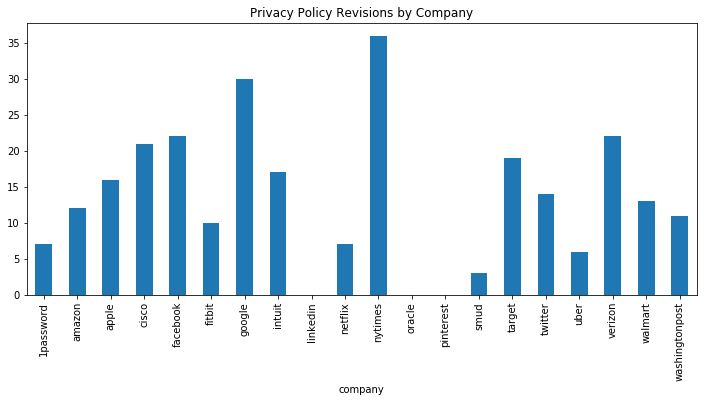

In [6]:
grouped = df.groupby('company').policy_path.count()
_ = grouped.plot.bar(title='Privacy Policy Revisions by Company', figsize=(12, 5))

What date range do the policies cover?

In [7]:
print('Oldest policy: {}'.format(min(df.policy_date).strftime('%Y-%m-%d')))
print('Most recent policy: {}'.format(max(df.policy_date).strftime('%Y-%m-%d')))

Oldest policy: 1999-06-09
Most recent policy: 2019-01-22


How many policies by year?

Warning: this plot makes it look like companies are making more revisions each year, but the positive trend might be the result of there simply being more active companies.

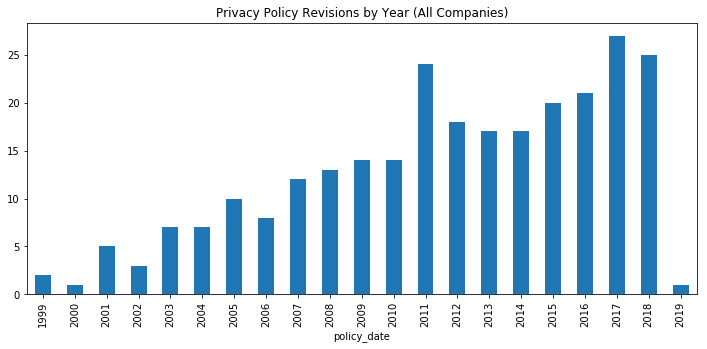

In [8]:
grouped = df.groupby([df.policy_date.dt.year]).policy_path.count()
_ = grouped.plot.bar(title='Privacy Policy Revisions by Year (All Companies)', figsize=(12, 5))

Can we normalize by number of active companies?

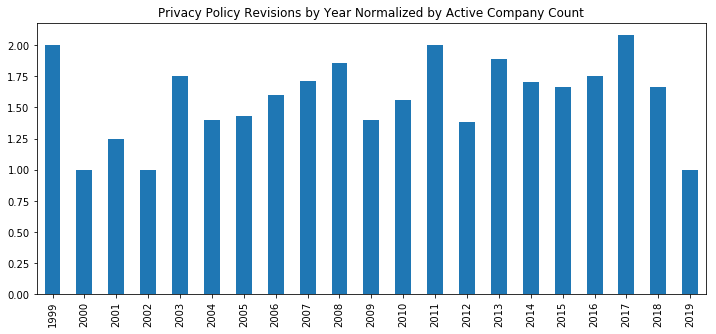

In [9]:
grouped = df.groupby([df.policy_date.dt.year, 'company']).policy_path.count()
# there's probably a better way to do this with pandas
values = defaultdict(int)
companies = defaultdict(set)
for index, value in grouped.items():
    values[index[0]] += value
    companies[index[0]].add(index[1])
    
normalized = dict()
for year, count in values.items():
    normalized[year] = count / len(companies[year])
    
pd.Series(normalized).plot.bar(
    title='Privacy Policy Revisions by Year Normalized by Active Company Count', figsize=(12, 5))

## The Privacy Policies

Now let's explore the policies themselves. We'll start by pulling all of the policy text into the dataframe, and then running some pandas cmds to gather metadata about the texts.

In [10]:
def get_policy_text(row):
    """
    Creates a pd.Series of full text from policies

    Args:
        row: pd.Series, row of policy index dataframe
        
    Returns:
        pd.Series, a new row with 'policy_text' col
    """
    page = ''
    with open(os.path.join(POLICY_DIR, row['policy_path']), 'r', encoding='utf-8') as f:
        page = f.read()
    row['policy_text'] = page
    return row

Looking inside again shows the same as before with the addition of the new text column

In [11]:
df = df.apply(get_policy_text, axis=1)
df.sample(n=10)

,company,policy_date,policy_url,policy_path,company_id,policy_text
229,target,2013-10-25,http://web.archive.org/web/20131128033829/http...,target/target-2013-10-25.txt,14,"\noops, there is a problem\nTarget.com require..."
60,cisco,2018-04-20,http://web.archive.org/web/20180509172321/http...,cisco/cisco-2018-04-20.txt,3,\nHome\nSkip to content\nSkip to footer\nWorld...
267,verizon,2009-06-10,http://web.archive.org/web/20100110214444/http...,verizon/verizon-2009-06-10.txt,17,\nPlease enable JavaScript while viewing this ...
283,walmart,2005-01-31,http://web.archive.org/web/20050204004437/http...,walmart/walmart-2005-01-31.txt,18,\nHome Page\n|\nYour Account\n|\nCart &amp; Ch...
188,nytimes,2015-04-29,http://web.archive.org/web/20150503042123/http...,nytimes/nytimes-2015-04-29.txt,10,\nHelp &gt; Permissions and Policies &gt; Priv...
223,target,2009-08-09,http://web.archive.org/web/20100414072853/http...,target/target-2009-08-09.txt,14,\nSkip to main content Site information and in...
119,google,2017-04-17,https://policies.google.com/privacy/archive/20...,google/google-2017-04-17.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
48,cisco,2010-06-02,http://web.archive.org/web/20100804214532/http...,cisco/cisco-2010-06-02.txt,3,\nHome |\nSkip to Content |\nSkip to Navigatio...
25,apple,2007-06-29,http://web.archive.org/web/20070630044333/http...,apple/apple-2007-06-29.txt,2,\nApple Customer Privacy Policy\nApple&#146;s ...
37,apple,2018-05-22,http://web.archive.org/web/20180606094136/http...,apple/apple-2018-05-22.txt,2,\nOpen Menu\nClose Menu\nApple\nShopping Bag\n...


How many total words?

In [12]:
print('Total words: {}'.format(df.policy_text.str.len().sum()))
print('Total occurences of "privacy": {}'.format(df.policy_text.str.count('privacy', flags=re.IGNORECASE).sum()))
print('Total occurences of "data": {}'.format(df.policy_text.str.count('data', flags=re.IGNORECASE).sum()))
print('Total occurences of "personal information": {}'.format(df.policy_text.str.count('personal information', flags=re.IGNORECASE).sum()))

Total words: 5835300
Total occurences of "privacy": 7577
Total occurences of "data": 3754
Total occurences of "personal information": 5075


How many words per company?

Warning: this might be slightly biased based on how long companies have been operating.

Warning: this is biased by number of revisions.

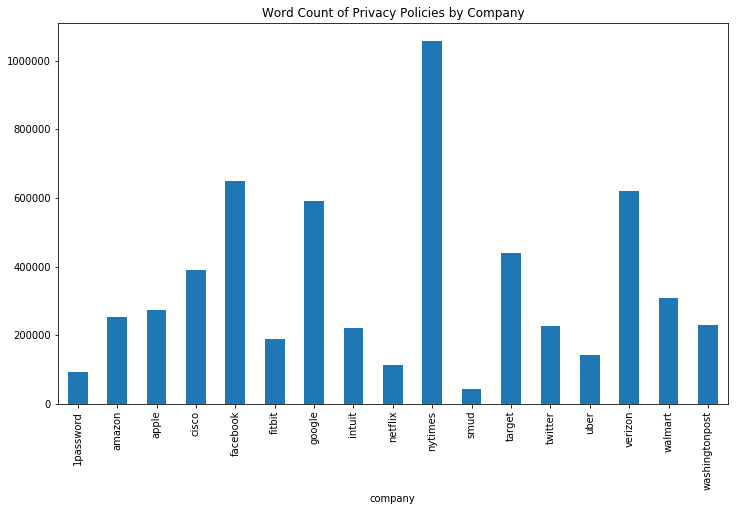

In [13]:
df_tmp = df.copy()
df_tmp['policy_len'] = df_tmp.policy_text.str.len()
grouped = df_tmp.groupby('company').policy_len.sum()
_ = grouped.plot.bar(title='Word Count of Privacy Policies by Company', figsize=(12, 7))

## Key Privacy Event Analysis

In the following sections, we investigate the impact that certain key legislative and popular events had on the privacy policies at large. We do this with a heatmap-derived visualization that shows us when certain terminology enters the vernacular of the policies per company.

In [14]:
def prepare_heatmap_data(data, ycol, xcol, valuecol, keep_last=True):
    """
    There has to be a better way to do this... but I procrastinated :)
    
    1. Pivot data and extend a policy's np.nan/0/1 up unto the next policy revision
       (originally, companies would have a 1 in the months where there were revisions
        followed by a string of np.nans and another 1 at the next revision)
    2. Fill the gaps between policy revision columns; create a new col for each
       year-month pair between the first and last policies in the dataset and extend
       between cols as before
    3. Rebuild new, complete dataframe
    """
    ### 1
    result = data.pivot(index=ycol, columns=xcol, values=valuecol)
    for i1, row in result.transpose().iteritems():
        last = np.nan
        for i2, value in row.iteritems():
            if np.isnan(value) and keep_last:
                # set it equal to last value
                value = last
            result.at[i1, i2] = value
            last = value

    ### 2
    min_date = result.columns.min()
    max_date = result.columns.max()
    companies = result.index

    last = None
    dates = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for year in range(min_date.year, max_date.year + 1):
        for month in range(1, 13):
            # create name of new col
            ym = date(year=year, month=month, day=1).strftime('%Y-%m')
            # get all old cols (y-m-d) that will need to be combined into this col
            col_matches = [x for x in result.columns if ym in str(x)]
            # if there are no revisions in this y-m, then just reuse last month's data
            if last and len(col_matches) == 0:
                col_matches = last
            # set data
            for col in col_matches:
                for company in companies:
                    dates[year][month][company] = result.at[company, col]
            last = col_matches

    ### 3
    new = pd.DataFrame(index=result.index)
    for year, months in dates.items():
        for month, companies in months.items():
            # new col
            ym = date(year=year, month=month, day=1).strftime('%Y-%m')
            for company, val in companies.items():
                if ym not in new.columns:
                    # create new col with np.nan
                    new[ym] = pd.Series([np.nan] * len(new.index))
                # set value
                new.at[company, ym] = val

    return new

In [15]:
def policy_heatmap(data, title, mask=True):
    # init plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(title)

    # prepare mask for null values when a company does not yet have a published privacy policy
    if mask:
        mask = np.zeros_like(result)
        mask[np.isnan(result)] = True
    else:
        mask = None

    # do plot
    # https://stackoverflow.com/questions/37790429/seaborn-heatmap-using-pandas-dataframe
    sp = sns.heatmap(data, ax=ax, fmt="g", cmap=sns.color_palette("RdBu", 7), mask=mask, cbar=False)

    # format and space xticks
    xlocs, xlabels = plt.xticks()
    #print(list(zip(xlocs, xlabels)))
    for i, x in enumerate(xlabels):
        text = ''
        if i % 6 == 0:
            text = x._text[:x._text.find('T')]
        xlabels[i]._text = text
    _ = ax.set_xticklabels(xlabels)    
    fig.autofmt_xdate()
    
    return ax

In [16]:
def review_regex_matches(data, filter_col, filter_key, buffer=20):
    return data[data[filter_col] == 1].policy_text.str.extract(
        '(.{0,' + str(buffer) + '}' + str(filter_key) + '.{0,' + str(buffer) + '})', flags=re.IGNORECASE|re.DOTALL)

In [17]:
def key_match_data(data, filter_key, extra_filters=None):
    """
    Args:
        data: pd.DataFrame
        filter_key: str, identifier of filter; will be used to create new boolean col
        extra_filters: list of str, additional filters joined by '|' to allow for permutations and additional words when filtering
        
    Returns:
        pd.DataFrame with an additional boolean col signaling if a filter is found in the row
    """
    df_copy = data.copy()
    filter_col = 'mentions_{}'.format(filter_key)
    # https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
    if extra_filters:
        filters = '|'.join([filter_key] + extra_filters)
    else:
        filters = filter_key
    df_copy[filter_col] = np.where(df_copy.policy_text.str.contains(filters, flags=re.IGNORECASE), 1, 0)
    print('{} / {} policies mention {}'.format(len(df_copy[df_copy[filter_col] == 1]), len(df_copy), filter_key))
    return df_copy, filter_col

### Children's Online Privacy Protection Act (COPPA)

From [Wikipedia](https://en.wikipedia.org/wiki/Children%27s_Online_Privacy_Protection_Act):

   "The act, effective April 21, 2000, applies to the online collection of personal information by persons or entities under
   U.S. jurisdiction about children under 13 years of age or children with disabilities. **It details what a website
   operator must include in a privacy policy**, when and how to seek verifiable consent from a parent or guardian, and what
   responsibilities an operator has to protect children's privacy and safety online including restrictions on the marketing
   of those under 13."

Based on the above, we should expect to see privacy policies mention their practices with children's data starting in April of 2000.

205 / 266 policies mention children


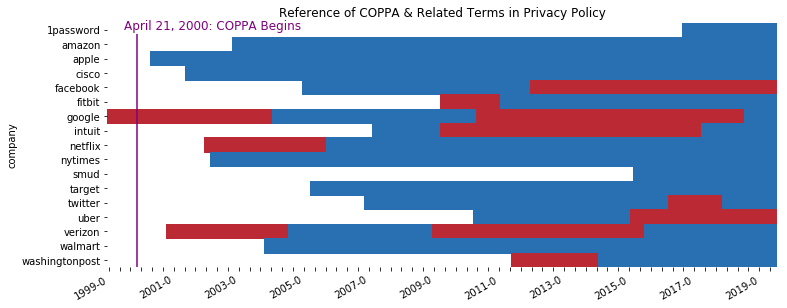

In [18]:
coppa, filter_col = key_match_data(df, 'children', ['children', 'child', 'minor', 'underage', 'teenager', 'Online Privacy Protection Act', 'coppa'])
result = prepare_heatmap_data(coppa, 'company', 'policy_date', filter_col)
ax = policy_heatmap(result, 'Reference of COPPA & Related Terms in Privacy Policy')
# add vertical line for coppa
_ = ax.vlines(11, .8, 20, color='purple')
_ = plt.text(6, 0.5, 'April 21, 2000: COPPA Begins', color='purple', fontsize=12)

Double-checking that our matches are reasonable

In [19]:
review_regex_matches(coppa, 'mentions_children', 'children').sample(n=10)

,0
84,ately upon posting.\nChildren\nWe do not want ...
70,No information from children under age 13. If yo
60,nd why.\nback to top\nChildren&#39;s Privacy\n...
170,\nOther information: Children's Guidelines\nOt...
100,NaN
223,his privacy policy.\nChildren\nWe recognize th...
8,ng on\nthe Internet. Children Amazon.com does not
305,portant Information Children’s Privacy. We do no
168,\nOther information: Children's Guidelines\nOt...
124,signed to appeal to children under the age of 13


## International Safe Harbor Privacy Principles

From [Wikipedia](https://en.wikipedia.org/wiki/International_Safe_Harbor_Privacy_Principles),

"The International Safe Harbor Privacy Principles or Safe Harbour Privacy Principles were principles **developed between 1998 and 2000** in order to prevent private organizations within the European Union or United States which store customer data from accidentally disclosing or losing personal information. **They were overturned on October 6, 2015 by the European Court of Justice (ECJ)**, which enabled some US companies to comply with privacy laws protecting European Union and Swiss citizens. US companies storing customer data could self-certify that they adhered to 7 principles, to comply with the EU Data Protection Directive and with Swiss requirements. The US Department of Commerce developed privacy frameworks in conjunction with both the European Union and the Federal Data Protection and Information Commissioner of Switzerland."

Let's see if "Safe Harbor" begins to disappear from policies around the year 2015.

75 / 266 policies mention safe\s*harbor


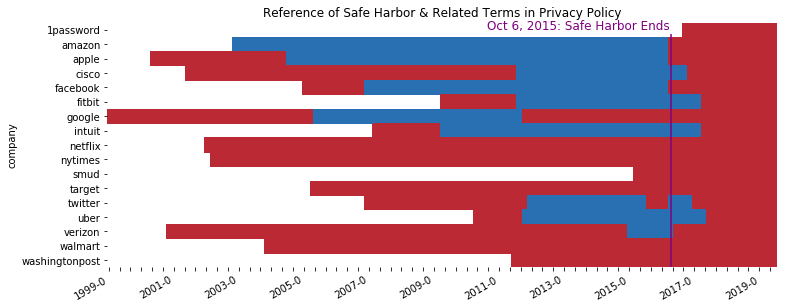

In [20]:
safeharbor, filter_col = key_match_data(df, 'safe\s*harbor')
result = prepare_heatmap_data(safeharbor, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of Safe Harbor & Related Terms in Privacy Policy')
# add vertical line for safe harbor
_ = ax.vlines(208, .8, 20, color='purple')
_ = plt.text(140, 0.5, 'Oct 6, 2015: Safe Harbor Ends', color='purple', fontsize=12)

In [21]:
review_regex_matches(safeharbor, filter_col, 'safe\s*harbor').sample(n=10)

,0
249,s with the US-Swiss Safe Harbor Framework and ...
50,ith the U.S.  E.U. Safe Harbor framework and ...
98,e adheres to the US safe harbor privacy princi...
247,and teens here.\nEU Safe Harbor Framework\nTw...
100,e adheres to the US Safe Harbor Privacy Princi...
272,a Privacy Rights\nEU Safe Harbor\nTRUSTe Certi...
70,can contact TRUSTe.Safe Harbor. Facebook also...
76,ngs you need to knowSafe harbor Facebook compl...
101,e adheres to the US Safe Harbor Privacy Princi...
32,bides by the &ldquo;safe harbor&rdquo; framewo...


### EU-US Privacy Shield

From [Wikipedia](https://en.wikipedia.org/wiki/EU%E2%80%93US_Privacy_Shield),

"In October 2015 the European Court of Justice declared the previous framework called the International Safe Harbor Privacy Principles invalid. Soon after this decision the European Commission and the U.S. Government started talks about a new framework and **on February 2, 2016 they reached a political agreement**. The European Commission published the 'adequacy decision' draft, declaring principles to be equivalent to the protections offered by EU law."

As we observed, references to "Safe Harbor" begin to disappear after 2015 to be replaced by this EU-US Privacy Shield, but how many websites complied?

30 / 266 policies mention shield


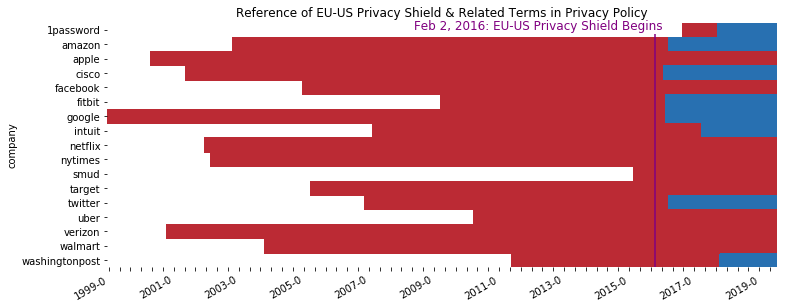

In [22]:
shield, filter_col = key_match_data(df, 'shield', ['EU-US\s*Privacy\s*Shield', 'EU-US'])
result = prepare_heatmap_data(shield, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of EU-US Privacy Shield & Related Terms in Privacy Policy')
# add vertical line for coppa
_ = ax.vlines(202, .8, 20, color='purple')
_ = plt.text(113, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [23]:
review_regex_matches(shield, filter_col, 'shield').sample(n=10)

,0
4,a U.S.-E.U. Privacy Shield Framework. See http
140,wiss - U.S. Privacy Shield Frameworks and comp
92,"nd Swiss-US Privacy Shield, and EU Commission"
308,rvices. Our Privacy Shield Policy governs use
5,a U.S.-E.U. Privacy Shield Framework. See http
249,h the EU-US Privacy Shield principles (the â
141,wiss - U.S. Privacy Shield Frameworks and comp
18,"nd Swiss-US Privacy Shield\nConditions of Use,"
17,".com?\nEU-US Privacy Shield\nConditions of Use,"
250,nd Swiss-US Privacy Shield principles (the â


### Popularity of "Personal Information"

251 / 266 policies mention personal\s*information


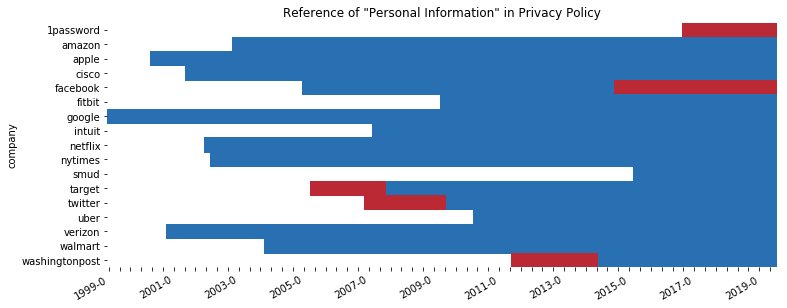

In [24]:
personalinfo, filter_col = key_match_data(df, 'personal\s*information')
result = prepare_heatmap_data(personalinfo, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Personal Information" in Privacy Policy')
# add vertical line for coppa
#_ = ax.vlines(180, .8, 20, color='purple')
#_ = plt.text(100, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [25]:
review_regex_matches(personalinfo, filter_col, 'personal\s*information').sample(n=10)

,0
138,ormation We Collect\nPersonal information such...
22,strive to keep your personal information confi...
32,llection and Use of Personal Information\nPers...
263,nd security of your personal information is ou...
151,tand how we use the personal information we as...
291,y Practices for its personal information pract...
154,"ormation, including personal information, abou..."
177,change or update my personal information?\nHow...
258,tes collect and use personal information to pr...
124,"identifies you as ""personal information"".\nWe..."


### Popularity of "Data Privacy"

15 / 266 policies mention data\s*privacy


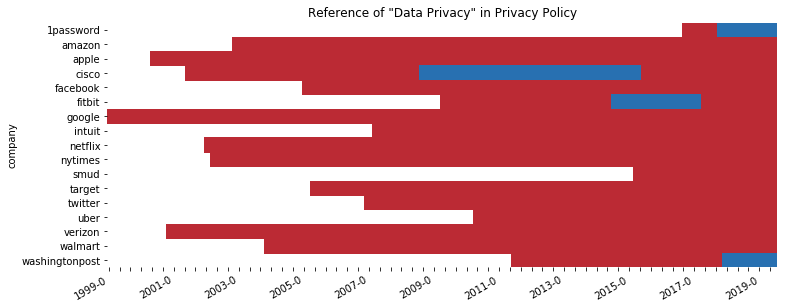

In [26]:
dataprivacy, filter_col = key_match_data(df, 'data\s*privacy')
result = prepare_heatmap_data(dataprivacy, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Data Privacy" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(180, .8, 20, color='purple')
#_ = plt.text(100, 0.5, 'Feb 2, 2016: EU-US Privacy Shield Begins', color='purple', fontsize=12)

In [27]:
review_regex_matches(dataprivacy, filter_col, 'data\s*privacy').sample(n=10)

,0
3,otection&rdquo; for data privacy of individual...
52,SA\nLearn more about Data Privacy\nPowering th...
51,nt\nLearn more about Data Privacy\nPowering th...
45,om\nLearn more about Data Privacy\nPowering th...
90,iveRamp Advertising Data Privacy Policy explai...
4,otection&rdquo; for data privacy of individual...
46,om\nLearn more about Data Privacy\nPowering th...
88,iveRamp Advertising Data Privacy Policy explai...
47,nt\nLearn more about Data Privacy\nPowering th...
50,nt\nLearn more about Data Privacy\nPowering th...


### Do Not Track

From [Wikipedia](https://en.wikipedia.org/wiki/Do_Not_Track_legislation),

"**On December 1, 2010**, the U.S. Federal Trade Commission (FTC) published a preliminary report highlighting the consumers’ right to prevent websites from tracking their online behaviors. The central plank of the bill was to adopt a Do Not Track opt-out function to web browsers. The FTC judged that online marketers’ pervasive collection of personal information could possibly violate privacy. **This issue began to surface again in 2012** after Google announced its new privacy policy. Reps. Edward Markey, Joe Barton, and Cliff Stearns asked the FTC to investigate the legality of Google’s change of privacy policy; they sent a letter to the FTC regarding Google’s changed privacy policy."

From the above, we imagine that we might begin to see Do Not Track references in 2010/2011 with more starting to surface in and after 2012.

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


57 / 266 policies mention (do\s*not\s*track|dnt)


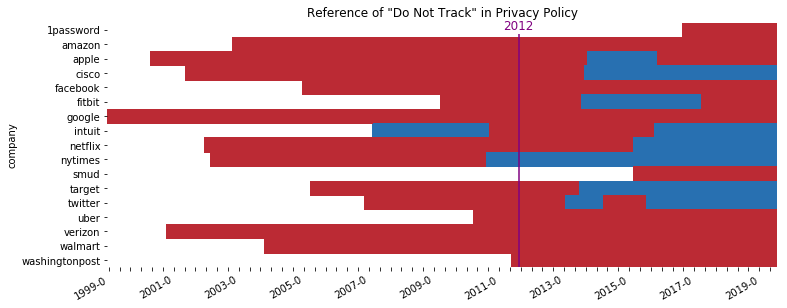

In [28]:
dnt_re = '(do\s*not\s*track|dnt)'
dnt, filter_col = key_match_data(df, dnt_re)
result = prepare_heatmap_data(dnt, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Do Not Track" in Privacy Policy')
# add vertical line for filter
_ = ax.vlines(152, .8, 20, color='purple')
_ = plt.text(146, 0.5, '2012', color='purple', fontsize=12)

In [29]:
review_regex_matches(dnt, filter_col, dnt_re).sample(n=10)

,0,1
51,you enable a &quot;do not track&quot; feature...,do not track
186,"d to browser-based ""do not track"" signals. For...",do not track
59,y to enable a &quot;do not track&quot; feature...,do not track
60,y to enable a &quot;do not track&quot; feature...,do not track
31,.\n&nbsp;\nCalifornia Do Not Track Disclosure&...,Do Not Track
183,Privacy Policy. We do not track or store a re...,do not track
157,"ond to Web browser ""do not track"" signals.\nHo...",do not track
250,ngs rather than the Do Not Track browser optio...,Do Not Track
249,okies. We honor the Do Not Track browser optio...,Do Not Track
53,"bility to enable a ""do not track"" feature that...",do not track


### General Data Protection Regulation (GDPR)

From [Wikipedia](https://en.wikipedia.org/wiki/General_Data_Protection_Regulation),

"The General Data Protection Regulation (EU) 2016/679 ('GDPR') is a regulation in EU law on data protection and privacy for all individuals within the European Union (EU) and the European Economic Area (EEA). It also addresses the export of personal data outside the EU and EEA areas. The GDPR aims primarily to give control to individuals over their personal data and to simplify the regulatory environment for international business by unifying the regulation within the EU.... **The GDPR was adopted on 14 April 2016, and became enforceable beginning 25 May 2018.** As the GDPR is a regulation, not a directive, it is directly binding and applicable, but does provide flexibility for certain aspects of the regulation to be adjusted by individual member states."

We should therefore see GDPR references in 2018.

8 / 266 policies mention gdpr


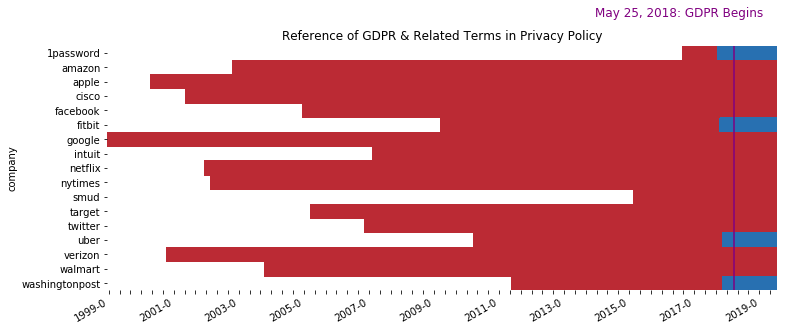

In [30]:
gdpr_re = 'gdpr|(General Data Protection Regulation)'
gdpr, filter_col = key_match_data(df, 'gdpr', ['General Data Protection Regulation'])
result = prepare_heatmap_data(gdpr, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of GDPR & Related Terms in Privacy Policy')
# add vertical line for filter
_ = ax.vlines(231, -5, 20, color='purple')
_ = plt.text(180, -2, 'May 25, 2018: GDPR Begins', color='purple', fontsize=12)

Interestingly, there are very few references to GDPR...

In [31]:
review_regex_matches(gdpr, filter_col, gdpr_re).sample(n=7)

,0,1
92,General Data Protection Regulation (&#x201C;GD...,General Data Protection Regulation
4,es.As stated in our GDPR,NaN
258,General Data Protection Regulation (“GDPR”).Th...,General Data Protection Regulation
5,es.As stated in our GDPR,NaN
308,General Data Protection Regulation. To make a ...,General Data Protection Regulation
93,General Data Protection Regulation (&#x201C;GD...,General Data Protection Regulation
3,es.As stated in our GDPR,NaN


Considering the flurry of privacy policy revision activity that supposedly occured before GDPR, perhaps we can visualizae that by not connecting the heatmap between revisions... Below is the attemppt to do exactly that and unfortunately it does not yield anything interesing.

8 / 266 policies mention gdpr


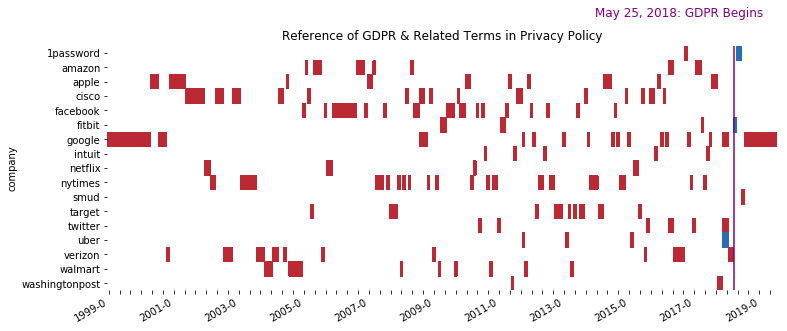

In [32]:
gdpr_re = 'gdpr|(General Data Protection Regulation)'
gdpr, filter_col = key_match_data(df, 'gdpr', ['General Data Protection Regulation'])
result = prepare_heatmap_data(gdpr, 'company', 'policy_date', filter_col, keep_last=False)
result.head()
ax = policy_heatmap(result, 'Reference of GDPR & Related Terms in Privacy Policy')
# add vertical line for filter
_ = ax.vlines(231, -5, 20, color='purple')
_ = plt.text(180, -2, 'May 25, 2018: GDPR Begins', color='purple', fontsize=12)

### Popularity of "Delete"

With GDPR came the notion of the "right to be forgotten" where you can request your data to be removed from a company's data stores. Let's see if GDPR adoption is signaled by the word "delete" making its way into privacy policies.

205 / 266 policies mention delet


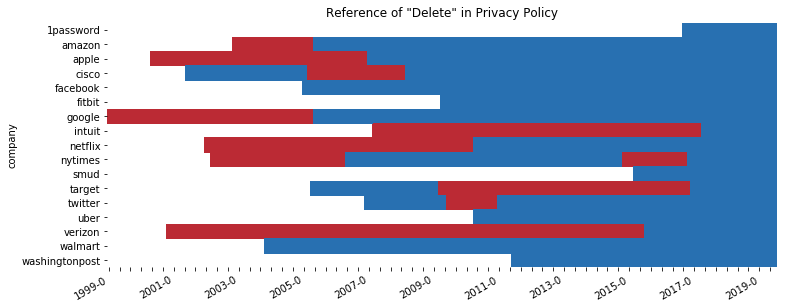

In [33]:
delete_re = 'delet'
delete, filter_col = key_match_data(df, delete_re)
result = prepare_heatmap_data(delete, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Delete" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(105, .8, 20, color='purple')
#_ = plt.text(100, 0.5, '2012', color='purple', fontsize=12)

Surprisingly, many companies supported deleting data before GPDR. Of course, this is not a complete check. This does not tell us to what extent these companies allowed you to delete your data.

In [34]:
review_regex_matches(delete, filter_col, delete_re).sample(n=10)

,0
9,formation\nAdding or Deleting Addresses\nChangi
308,"nformation, we will delete it in accordance w"
256,ve the issue before deleting your information
181,e e-mail address is deleted. Access to the ab
103,is inaccurate or to delete such data at your
139,bility to change or delete your Personal Info
25,we will attempt to delete the information as
294,and we will work to delete it.\nPrivacy of Mob
306,"nformation, we will delete it in accordance w"
194,"orrect, restrict or delete personal informati"


### Popularity of "Forgotten"

0 / 266 policies mention forgotten


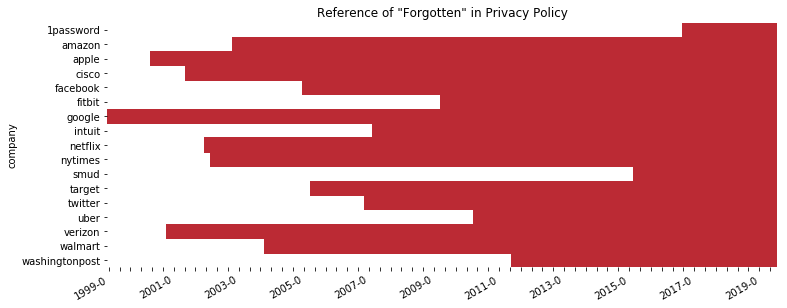

In [35]:
forgot_re = 'forgotten'
forgot, filter_col = key_match_data(df, forgot_re)
result = prepare_heatmap_data(forgot, 'company', 'policy_date', filter_col)
result.head()
ax = policy_heatmap(result, 'Reference of "Forgotten" in Privacy Policy')
# add vertical line for filter
#_ = ax.vlines(105, .8, 20, color='purple')
#_ = plt.text(100, 0.5, '2012', color='purple', fontsize=12)

In [36]:
review_regex_matches(forgot, filter_col, forgot_re)

,0


### TRUSTe

## Google

In [37]:
google = df[df.company == 'google']
google.head()

,company,policy_date,policy_url,policy_path,company_id,policy_text
94,google,1999-06-09,https://policies.google.com/privacy/archive/19...,google/google-1999-06-09.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
95,google,1999-09-20,https://policies.google.com/privacy/archive/19...,google/google-1999-09-20.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
96,google,2001-01-04,https://policies.google.com/privacy/archive/20...,google/google-2001-01-04.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
97,google,2004-07-01,https://policies.google.com/privacy/archive/20...,google/google-2004-07-01.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
98,google,2005-10-14,https://policies.google.com/privacy/archive/20...,google/google-2005-10-14.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...


In [38]:
google = google.apply(get_policy_text, axis=1)

In [39]:
google['policy_text_len'] = google.policy_text.str.len()

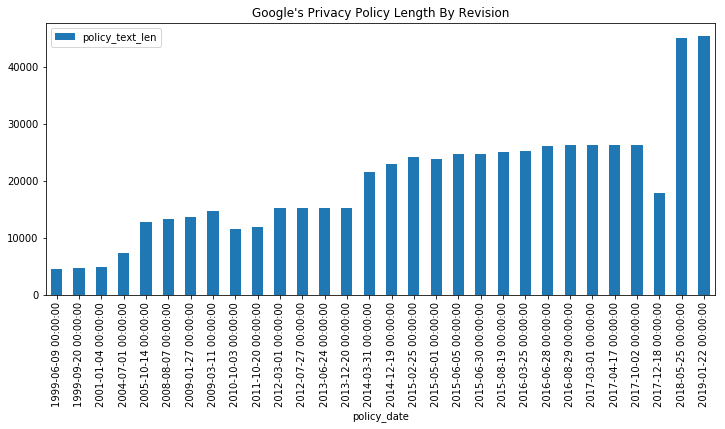

In [40]:
google[['policy_date', 'policy_text_len']].plot.bar('policy_date', title="Google's Privacy Policy Length By Revision", figsize=(12, 5))

## Readability Metrics

To limit noise and increase the value of this analysis, it was not performed on all the companies in the dataset and was instead restricted to the companies commonly referred to as FAANG (Facebook, Apple, Amazon, Netflix, Google) as these companies are large players in the world of data.

In [61]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


def prepare_line_data(data, ycol, xcol, valuecol, entities, keep_last=True):
    result = data.pivot(index=ycol, columns=xcol, values=valuecol)
    # make index a dedicated column so that it'll play nice with the line plot later
    lasts = {c:np.nan for c in entities}
    for i1, row in result.transpose().iteritems():
        last = np.nan
        for i2, value in row.iteritems():
            if np.isnan(value) and keep_last:
                # set it equal to last value
                value = lasts[i2]
            result.at[i1, i2] = value
            lasts[i2] = value
    result[ycol] = result.index
    return result


def policy_line_plot(data, xcol, entities, colors, title, ylabel, xlabel='Policy Publication Date'):    
    """
    Args:
        data: pd.DataFrame, data to plot
        xcol: str, name of column to plot on xaxis
        entities: list of str, name of entities to appear in legend and as lines
        colors: dict, map between entity name and line color
        ylabel: str, y axis label
        xlabel: str, x axis label (optional)
        
    
    """
    f, ax = plt.subplots(1, figsize=(12, 7))
    for ent in entities:
        data.plot.line(x=xcol, y=ent, color=colors[ent], ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcworkma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
faang_companies = ['facebook', 'apple', 'amazon', 'netflix', 'google']
faang = df[df['company'].str.contains('|'.join(faang_companies))]
print(len(faang))
print(faang.company.unique())
faang.sample(n=10)

87
['amazon' 'apple' 'facebook' 'google' 'netflix']


,company,policy_date,policy_url,policy_path,company_id,policy_text
20,apple,2000-10-31,http://web.archive.org/web/20001109193900/http...,apple/apple-2000-10-31.txt,2,\nProtecting your privacy is important to Appl...
33,apple,2016-09-12,http://web.archive.org/web/20160930114658/http...,apple/apple-2016-09-12.txt,2,\nOpen Menu\nClose Menu\nApple\nShopping Bag\n...
13,amazon,2007-08-29,http://web.archive.org/web/20070908160725/http...,amazon/amazon-2007-08-29.txt,1,\n&nbsp;\nYourAmazon.comSee all 41Product&nbsp...
119,google,2017-04-17,https://policies.google.com/privacy/archive/20...,google/google-2017-04-17.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
75,facebook,2011-09-07,http://web.archive.org/web/20110915075435/http...,facebook/facebook-2011-09-07.txt,4,EmailPasswordKeep me logged inForgot your pass...
8,amazon,2005-07-20,http://web.archive.org/web/20050801090733/http...,amazon/amazon-2005-07-20.txt,1,\n&nbsp;\nHelp\n&gt;\nPrivacy &amp; Security\n...
157,netflix,2018-05-11,http://web.archive.org/web/20181221043504/http...,netflix/netflix-2018-05-11.txt,9,\nHelp Center\nHelp Center\nSign In\nStart You...
106,google,2013-06-24,https://policies.google.com/privacy/archive/20...,google/google-2013-06-24.txt,6,Privacy &amp; TermsOverviewPrivacy PolicyTerms...
25,apple,2007-06-29,http://web.archive.org/web/20070630044333/http...,apple/apple-2007-06-29.txt,2,\nApple Customer Privacy Policy\nApple&#146;s ...
32,apple,2016-05-31,http://web.archive.org/web/20160602073409/http...,apple/apple-2016-05-31.txt,2,\nOpen Menu\nClose Menu\nApple\nShopping Bag\n...


In [63]:
# init colors now for standardization across plots
colors = ['red', 'orange', 'violet', 'green', 'blue']
faang_colors = {x:colors[i] for i, x in enumerate(faang_companies)}

### Lexicon Count

Number of words

In [64]:
# quick check to make sure that split isn't going to have a problem with newline character
faang['policy_text'].str.split().str.contains('\n').unique()

array([nan])

In [65]:
faang['lexicon_count'] = faang['policy_text'].str.split().str.len()
faang['lexicon_count'].describe()

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count      87.000000
mean     3379.137931
std      1740.356667
min       667.000000
25%      2307.000000
50%      3126.000000
75%      3845.500000
max      9233.000000
Name: lexicon_count, dtype: float64

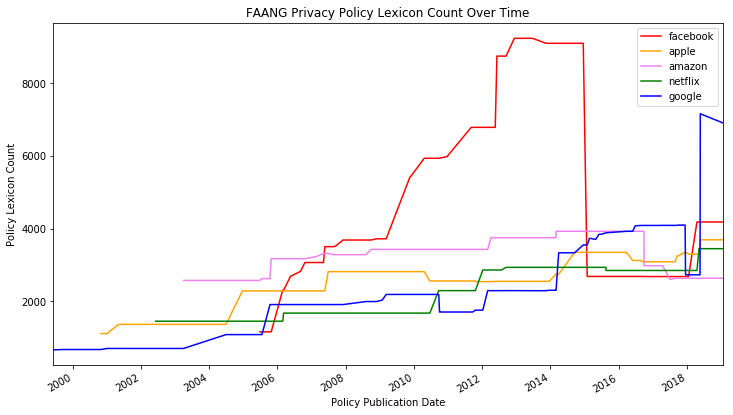

In [66]:
result = prepare_line_data(faang, 'policy_date', 'company', 'lexicon_count', faang_companies)
_ = policy_line_plot(result,
                     'policy_date',
                     faang_companies,
                     faang_colors,
                     'FAANG Privacy Policy Lexicon Count Over Time',
                     'Policy Lexicon Count')

### Syllables Count

Number of syllables

In [67]:
# https://stackoverflow.com/questions/46759492/syllable-count-in-python
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

syllable_count('banana')

3

In [68]:
# brute force it
sylcounts = list()
faang['syllable_count'] = pd.Series([0] * len(faang))
for index, row in faang.iterrows():
    split = row['policy_text'].split()
    counts = list(map(syllable_count, split))
    sumcounts = sum(counts)
    #print(row['company'], sumcounts)
    sylcounts.append(sumcounts)
    faang.at[index, 'syllable_count'] = sumcounts

faang['syllable_count'].describe()

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count       87.000000
mean      5978.287356
std       2857.108120
min       1255.000000
25%       4250.000000
50%       5742.000000
75%       6836.500000
max      15144.000000
Name: syllable_count, dtype: float64

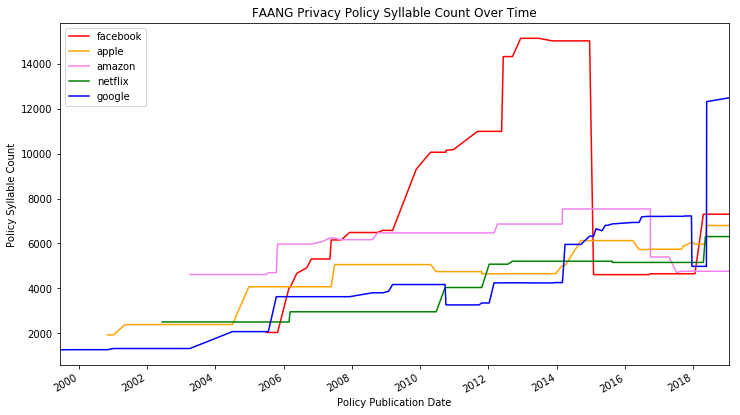

In [69]:
result = prepare_line_data(faang, 'policy_date', 'company', 'syllable_count', faang_companies)
_ = policy_line_plot(result,
                     'policy_date',
                     faang_companies,
                     faang_colors,
                     'FAANG Privacy Policy Syllable Count Over Time',
                     'Policy Syllable Count')

### Sentence Count

Number of sentences

In [70]:
# https://stackoverflow.com/questions/15228054/how-to-count-the-amount-of-sentences-in-a-paragraph-in-python
faang['sentence_count'] = faang['policy_text'].apply(sent_tokenize).str.len()
faang['sentence_count'].describe()

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count     87.000000
mean     133.873563
std       62.544645
min       31.000000
25%      100.500000
50%      119.000000
75%      170.500000
max      305.000000
Name: sentence_count, dtype: float64

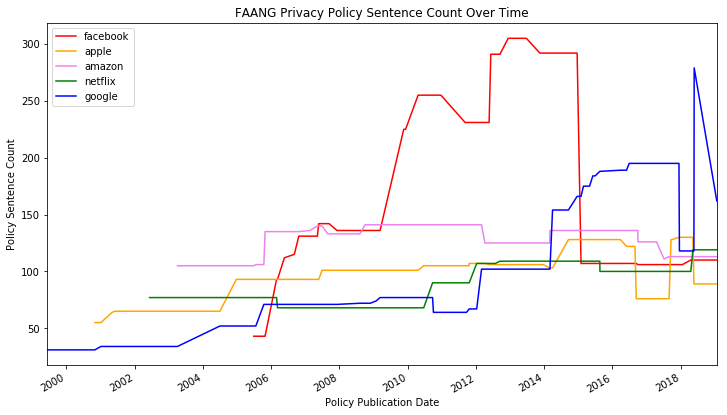

In [71]:
result = prepare_line_data(faang, 'policy_date', 'company', 'sentence_count', faang_companies)
_ = policy_line_plot(result,
                     'policy_date',
                     faang_companies,
                     faang_colors,
                     'FAANG Privacy Policy Sentence Count Over Time',
                     'Policy Sentence Count')

### Passive Voice Index

Percentage of sentences with passive verb forms

### Flesch Kincaid Measures

Readability measure presented as U.S. grade level. The test is also available as a "reading ease" test, but here the grade level measure is used as it is more intuitive (Kincaid et al., 1981) [[Wikipedia](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests)].

Flesch Kincaid Reading Ease Test

![equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e)

Flesch Kincaid Grade Level Test

![equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/8e68f5fc959d052d1123b85758065afecc4150c3)

In [80]:
def flesch_kincaid_reading_ease(words, sentences, syllables):
    return 206.835 - 1.015 * (words / sentences) - 84.6 * (syllables / words)

def flesch_kincaid_grade_level(words, sentences, syllables):
    return 0.39 * (words / sentences) + 11.8 * (syllables / words) - 15.59

In [81]:
faang['flesch_kincaid'] = flesch_kincaid_grade_level(faang['lexicon_count'], faang['sentence_count'], faang['syllable_count'])
faang['flesch_kincaid'].describe()

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    87.000000
mean     15.368265
std       1.914089
min      12.046285
25%      14.129570
50%      15.000259
75%      15.929738
max      22.379443
Name: flesch_kincaid, dtype: float64

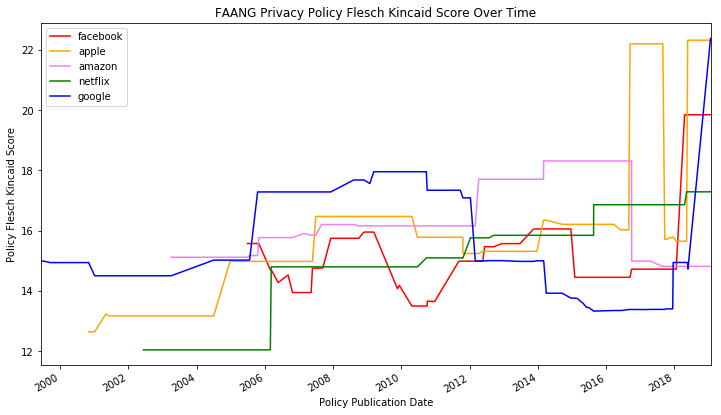

In [82]:
result = prepare_line_data(faang, 'policy_date', 'company', 'flesch_kincaid', faang_companies)
_ = policy_line_plot(result,
                     'policy_date',
                     faang_companies,
                     faang_colors,
                     'FAANG Privacy Policy Flesch Kincaid Score Over Time',
                     'Policy Flesch Kincaid Score')

### Dale-Chall Readability Score

Assess readability based on the use of 3000 words reliably understood by groups of fourth-grade American students (Dale and Chall, 1948) [[Wikipedia](https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula).

![equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/0541f1e629f0c06796c5a5babb3fac8d100a858c)

Computed with help from the [textstat](https://pypi.org/project/textstat/) python package

In [75]:
import textstat
faang['dale_chall'] = faang['policy_text'].apply(textstat.dale_chall_readability_score)
faang['dale_chall'].describe()

C:\Users\jcworkma\Documents\personal\gradschool\berkeley\W231\privacy-policies-through-time\.pptt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    87.000000
mean      7.027356
std       0.409930
min       6.110000
25%       6.805000
50%       6.990000
75%       7.355000
max       8.090000
Name: dale_chall, dtype: float64

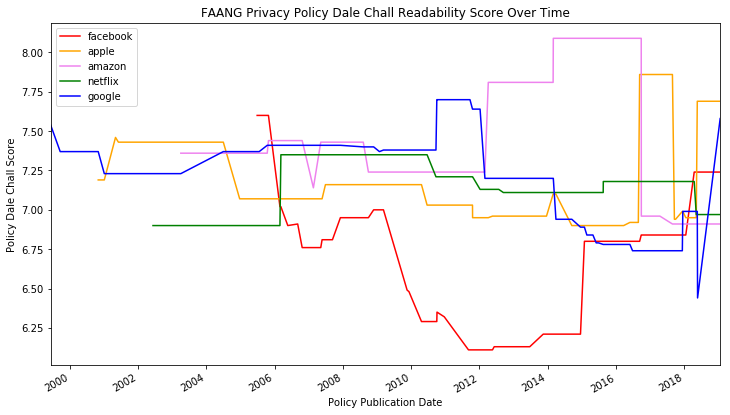

In [76]:
result = prepare_line_data(faang, 'policy_date', 'company', 'dale_chall', faang_companies)
_ = policy_line_plot(result,
                     'policy_date',
                     faang_companies,
                     faang_colors,
                     'FAANG Privacy Policy Dale Chall Readability Score Over Time',
                     'Policy Dale Chall Score')